<a href="https://colab.research.google.com/github/zualexander/mai-aiapp-computer-vision/blob/main/mai_computer_vision_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tarfile
import os
import splitfolders
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

#variables

In [3]:
batch_size = 32
epochs = 50
img_size = 256
train_data_path = '/tmp/dataset/output/train/'
val_data_path = '/tmp/dataset/output/val/'

#Functions

In [4]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy_and_loss(history):

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Download Dataset
from [howto](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e)

In [5]:
!wget --no-check-certificate \
    ""http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"" \
    -O "/tmp/dataset.tar.gz"

--2022-06-05 09:45:42--  http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz
Resolving aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)... 132.230.105.132
Connecting to aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)|132.230.105.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541562880 (516M) [application/x-gzip]
Saving to: ‘/tmp/dataset.tar.gz’

/tmp/dataset.tar.gz 100%[===================>] 516.47M  20.1MB/s    in 28s     

2022-06-05 09:46:11 (18.2 MB/s) - ‘/tmp/dataset.tar.gz’ saved [541562880/541562880]



In [6]:
!mkdir /tmp/dataset 
!tar xf /tmp/dataset.tar.gz --directory=/tmp/dataset

# Datasplit

In [7]:
splitfolders.ratio("/tmp/dataset/images", output="/tmp/dataset/output",
    seed=1337, ratio=(.75, .25), group_prefix=None, move=False)

Copying files: 4947 files [00:02, 2249.91 files/s]


In [8]:
ls /tmp/dataset/output/train

BEANS/   CHIPS/      FISH/   JUICE/  PASTA/   SUGAR/         WATER/
CAKE/    CHOCOLATE/  FLOUR/  MILK/   RICE/    TEA/
CANDY/   COFFEE/     HONEY/  NUTS/   SODA/    TOMATO_SAUCE/
CEREAL/  CORN/       JAM/    OIL/    SPICES/  VINEGAR/


In [9]:
train = keras.utils.image_dataset_from_directory(
    directory=train_data_path,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=(img_size, img_size))

validation = keras.utils.image_dataset_from_directory(
    directory=val_data_path,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=(img_size, img_size))


Found 3699 files belonging to 25 classes.
Found 1248 files belonging to 25 classes.


In [10]:
print(len(train.class_names))
classes=train.class_names

25


## data generator

In [11]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(                      
    rotation_range=90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2
    )

In [12]:
val_datagen = keras.preprocessing.image.ImageDataGenerator()

In [13]:
train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 3699 images belonging to 25 classes.


In [14]:
val_generator = val_datagen.flow_from_directory(val_data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 1248 images belonging to 25 classes.


# Model

In [15]:
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
    classes=len(classes)
) 

94781440/94765736 [==============================] - 0s 0us/step


In [16]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
resnet_model.count_params()

23587712

In [18]:
model = keras.models.Sequential()

for layer in resnet_model.layers:
        layer.trainable=False

model.add(resnet_model)

In [19]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(len(classes), activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                                 
Total params: 90,709,913
Trainable params: 67,122,201
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
model.count_params()

90709913

In [22]:
#compile model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

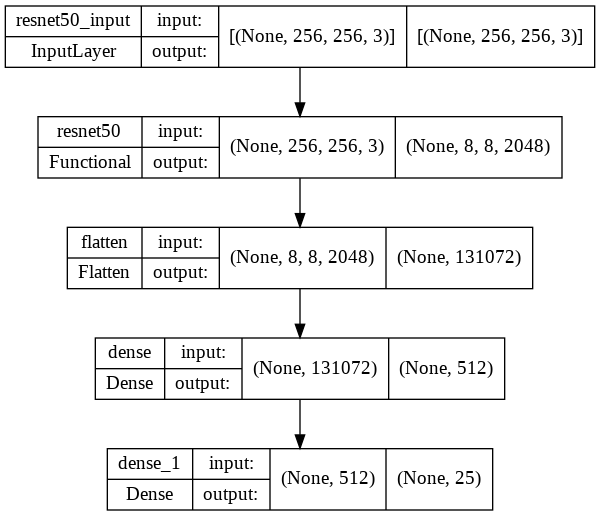

In [23]:
keras.utils.plot_model(model,show_shapes=True)

In [24]:
hist = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

Epoch 1/50
116/116 [==============================] - 86s 620ms/step - loss: 11.2212 - acc: 0.1281 - val_loss: 2.9361 - val_acc: 0.1450
Epoch 2/50
116/116 [==============================] - 70s 602ms/step - loss: 2.8696 - acc: 0.1941 - val_loss: 2.7524 - val_acc: 0.1979
Epoch 3/50
116/116 [==============================] - 70s 605ms/step - loss: 2.7111 - acc: 0.2155 - val_loss: 2.5470 - val_acc: 0.2684
Epoch 4/50
116/116 [==============================] - 70s 607ms/step - loss: 2.5666 - acc: 0.2493 - val_loss: 2.5564 - val_acc: 0.2452
Epoch 5/50
116/116 [==============================] - 71s 610ms/step - loss: 2.5234 - acc: 0.2633 - val_loss: 2.3656 - val_acc: 0.2949
Epoch 6/50
116/116 [==============================] - 70s 605ms/step - loss: 2.4226 - acc: 0.2849 - val_loss: 2.2105 - val_acc: 0.3381
Epoch 7/50
116/116 [==============================] - 70s 602ms/step - loss: 2.2963 - acc: 0.3033 - val_loss: 2.1700 - val_acc: 0.3165
Epoch 8/50
116/116 [==============================] - 

#Model evaluation

##trainigs history

In [25]:
print ("test accuracy ", hist.history['acc'][-1])

test accuracy  0.6350364685058594


#validation history

In [26]:
print ("validation accuracy ", hist.history['val_acc'][-1])

validation accuracy  0.6017628312110901


#accuracy and loss plot

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


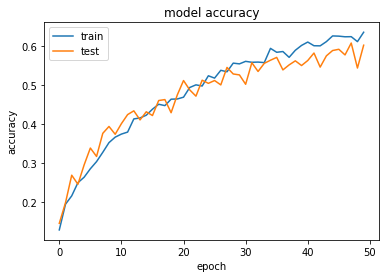

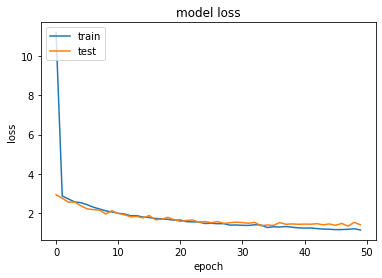

In [27]:
print(hist.history.keys())
plot_accuracy_and_loss(hist)

#Confusion matrix

In [41]:
def print_confusion_matrix(classes, val_generator):
  Y_pred = model.predict_generator(val_generator)
  y_pred = np.argmax(Y_pred, axis=1)
  con_mat = confusion_matrix(val_generator.classes, y_pred)
  print('Confusion Matrix')
  print(con_mat)
  print('Classification Report')
  #print(classification_report(val_generator.classes, y_pred, target_names=val_generator.classes))

  ## plot
  sns.set_theme(style='darkgrid')

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat, annot=True,cmap=plt.cm.Dark2)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[ 2  3  4  0  2  3  2  2  2  0  2  1  0  1  0  0  1  0  2  2  0  2  1  0
   2]
 [ 0  1  3  1  2  6  2  4  0  1  4  2  0  0  3  3  0  1  0  1  0  4  0  2
   1]
 [ 2  6  6 11  1  8  6  1  0  0  2  8  4  5  1  4  0  0  1  5  5  5  2  6
   4]
 [ 1  1  3  2  3  2  4  2  4  1  4  1  1  6  4  7  0  0  4  3  1  5  4  4
   3]
 [ 1  2  3  1  2  5  3  4  0  0  3  3  1  4  1  0  0  0  1  1  2  1  3  2
   3]
 [ 1  2  5  3  3 10  3  5  2  0  5  7  5  2  2  2  0  1  0  1  3  5  2  4
   4]
 [ 2  6  6  3  3  8  2  2  0  0  2  3  5  4  1  1  0  1  0  2  7  4  0  5
   8]
 [ 0  5  2  1  0  2  3  0  2  0  1  0  0  0  0  3  0  1  0  0  0  3  0  0
   2]
 [ 2  1  2  1  1  0  2  2  1  0  1  0  0  3  1  0  0  1  0  3  1  2  2  2
   0]
 [ 0  2  3  3  1  2  3  1  2  0  2  0  2  0  0  1  0  0  1  1  1  1  0  1
   1]
 [ 2  4  8  0  1  3  1  2  1  1  1  2  2  5  1  0  0  1  2  2  2  1  2  2
   1]
 [ 1  4  5  2  2  2  2  1  2  0  3  6  3  3  3  2  0  2  0  2  3  3  2  3
   5]
 [ 0  5  5  4  2  7  6 

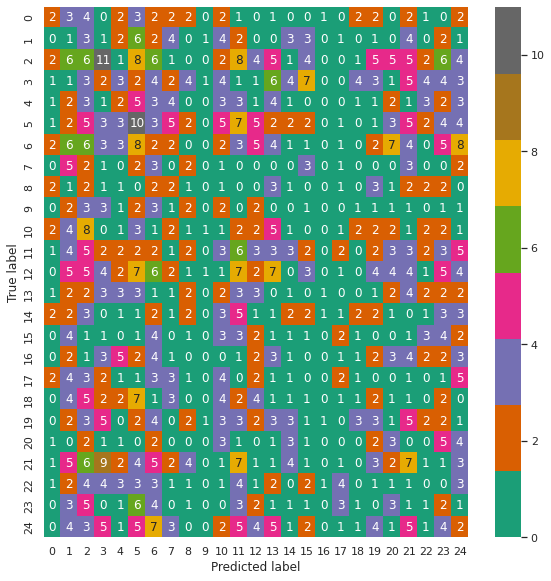

In [42]:
print_confusion_matrix(classes, val_generator)

In [30]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

INFO:tensorflow:Assets written to: saved_model/final_model_exp_2/assets


In [31]:
model.save('saved_model/final_model_exp_2')

INFO:tensorflow:Assets written to: saved_model/final_model_exp_2/assets


In [36]:
custom_train_generator = keras.preprocessing.image.ImageDataGenerator()

In [37]:
custom_gen = custom_train_generator.flow_from_directory('./classes',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 14 images belonging to 26 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0]]
Classification Report


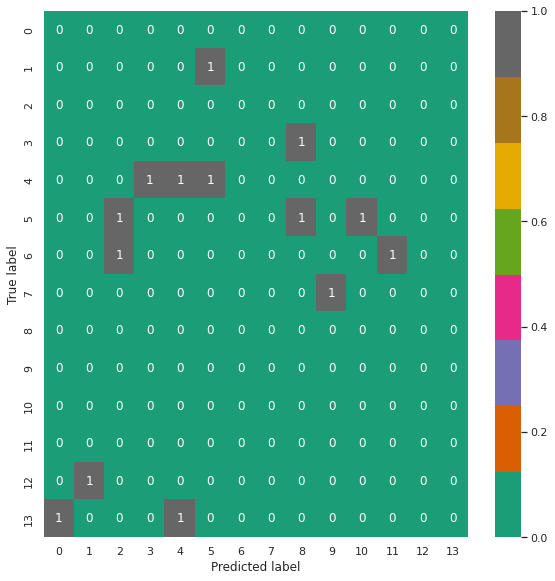

In [43]:
print_confusion_matrix(classes, custom_gen)